In [ ]:
!pip install tqdm

In [101]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [102]:
train_df = pd.read_parquet('train.parquet')
test_df = pd.read_parquet('test.parquet')

# 1. EDA

In [103]:
train_df.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


In [104]:
test_df.head(3)

,id,dates,values
0,6125,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91..."
1,26781,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.41, 0.39, -0.47, -0.9, -1.46, -0.51, 0.51,..."
2,13333,"[2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...","[-0.29, -1.26, 0.17, -1.22, 0.45, -0.94, 0.16,..."


In [105]:
train_df.shape, test_df.shape

((80000, 4), (20000, 3))

### Соотношение классов в тренировочных данных

In [106]:
train_df["label"].mean()

0.27725

### Попробуем UnderSampling чтобы сбалансировать данные

In [107]:
class_0_count = train_df['label'].value_counts()[0]
class_1_count = train_df['label'].value_counts()[1]

min_count = min(class_0_count, class_1_count)

train_df_balanced = pd.concat([
    train_df[train_df['label'] == 0].sample(min_count, random_state=42),
    train_df[train_df['label'] == 1].sample(min_count, random_state=42)
])

In [108]:
train_df_balanced.shape

(44360, 4)

### Приводим данные к формату 2d-массива (n_samples, n_datetime_points)

In [109]:
X_train_list = []
y_train = []

for index, row in train_df.iterrows():
    time_index = pd.Index(row['dates'])  
    values = np.array(row['values'])  
    time_series = pd.Series(values, index=time_index) 
    X_train_list.append(time_series)  
    y_train.append(row['label'])  

X_train = pd.DataFrame(X_train_list)  
y_train = np.array(y_train)

In [110]:
X_train_balanced_list = []
y_train_balanced = []

for index, row in train_df_balanced.iterrows():
    time_index = pd.Index(row['dates'])  
    values = np.array(row['values'])  
    time_series = pd.Series(values, index=time_index) 
    X_train_balanced_list.append(time_series)  
    y_train_balanced.append(row['label'])  

X_train_balanced = pd.DataFrame(X_train_balanced_list)  
y_train_balanced = np.array(y_train_balanced)

In [111]:
X_train

,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,...,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01
0,-1.86,0.79,1.40,0.15,0.00,-1.24,-1.46,3.49,1.20,1.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,-1.04,-3.48,0.05,-0.13,-0.01,0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.33,0.58,1.10,-0.56,-0.95,-0.61,-0.70,-1.35,-0.77,-0.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.31,0.50,-0.54,0.95,0.65,0.83,-1.55,-0.28,-1.24,0.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79996,NaN,NaN,NaN,NaN,NaN,NaN,-0.35,-1.31,0.11,1.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79997,NaN,NaN,-0.78,-2.27,-1.85,-0.67,-1.20,-2.02,0.12,-1.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79998,NaN,-2.29,-2.85,0.92,-0.83,-1.75,-1.81,-2.29,1.67,0.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Заполняем пропуски по принципу ступенчатой функции (для неизвестных периодов времени назначая последнее известное значение)

In [112]:
X_train = X_train.apply(lambda x: x.ffill(), axis=1)
X_train = X_train.apply(lambda x: x.bfill(), axis=1)

X_train_balanced = X_train_balanced.apply(lambda x: x.ffill(), axis=1)
X_train_balanced = X_train_balanced.apply(lambda x: x.bfill(), axis=1)

X_train

,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,...,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01
0,-1.86,0.79,1.40,0.15,0.00,-1.24,-1.46,3.49,1.20,1.93,...,-0.570000,-0.570000,-0.570000,-0.570000,-0.570000,-0.570000,-0.570000,-0.570000,-0.570000,-0.570000
1,-1.04,-1.04,-1.04,-1.04,-1.04,-3.48,0.05,-0.13,-0.01,0.03,...,-0.054409,-0.054409,-0.054409,-0.054409,-0.054409,-0.054409,-0.054409,-0.054409,-0.054409,-0.054409
2,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,...,-0.420000,-0.420000,-0.420000,-0.420000,-0.420000,-0.420000,-0.420000,-0.420000,-0.420000,-0.420000
3,-0.33,0.58,1.10,-0.56,-0.95,-0.61,-0.70,-1.35,-0.77,-0.94,...,1.590000,1.590000,1.590000,1.590000,1.590000,1.590000,1.590000,1.590000,1.590000,1.590000
4,1.31,0.50,-0.54,0.95,0.65,0.83,-1.55,-0.28,-1.24,0.51,...,-0.750000,-0.750000,-0.750000,-0.750000,-0.750000,-0.750000,-0.750000,-0.750000,-0.750000,-0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,...,2.180000,2.180000,2.180000,2.180000,2.180000,2.180000,2.180000,2.180000,2.180000,2.180000
79996,-0.35,-0.35,-0.35,-0.35,-0.35,-0.35,-0.35,-1.31,0.11,1.46,...,-0.170319,-0.170319,-0.170319,-0.170319,-0.170319,-0.170319,-0.170319,-0.170319,-0.170319,-0.170319
79997,-0.78,-0.78,-0.78,-2.27,-1.85,-0.67,-1.20,-2.02,0.12,-1.39,...,-2.890000,-2.890000,-2.890000,-2.890000,-2.890000,-2.890000,-2.890000,-2.890000,-2.890000,-2.890000
79998,-2.29,-2.29,-2.85,0.92,-0.83,-1.75,-1.81,-2.29,1.67,0.97,...,0.670000,0.670000,0.670000,0.670000,0.670000,0.670000,0.670000,0.670000,0.670000,0.670000


### Обнаружились полностью пустые строки

In [116]:
print(X_train[X_train.isnull().any(axis=1) | (X_train == '').any(axis=1)].shape,
X_train_balanced[X_train_balanced.isnull().any(axis=1) | (X_train_balanced == '').any(axis=1)].shape)

(88, 97) (68, 97)


### Удаляем их

In [117]:
X_train = X_train.dropna(axis=0)
y_train = y_train[X_train.index]

X_train_balanced = X_train_balanced.dropna(axis=0)
y_train_balanced = y_train_balanced[X_train_balanced.index]

X_train.shape, y_train.shape, X_train_balanced.shape, y_train_balanced.shape

((79912, 97), (79912,), (44292, 97), (44292,))

### Посмотрим на небольшом подсемпле возможно ли визуально разделить временные ряды разных классов

In [118]:
import matplotlib.pyplot as plt

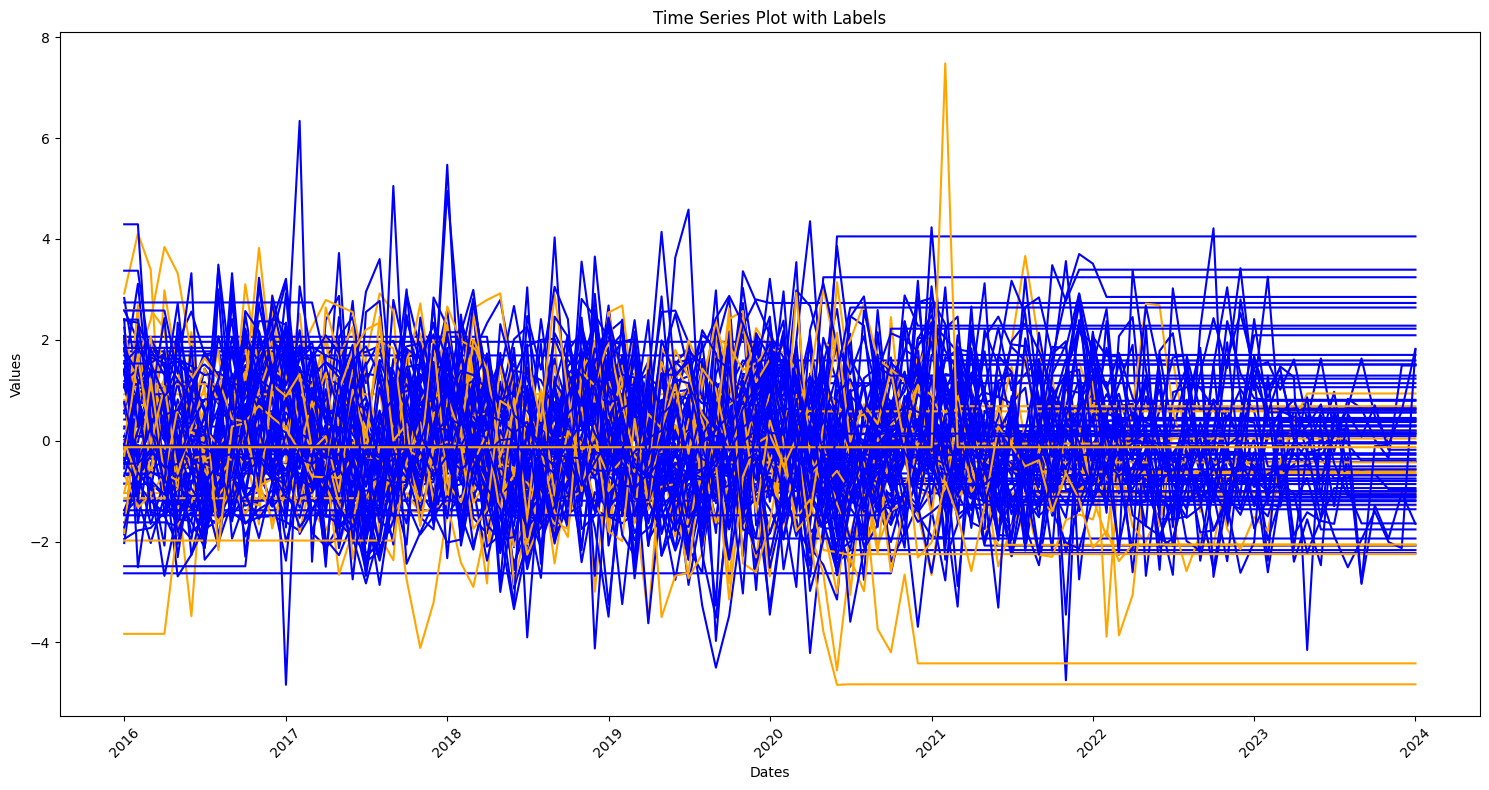

In [119]:
num_series = 100

selected_series = X_train.iloc[:num_series]
selected_labels = pd.Series(y_train[:num_series])

plt.figure(figsize=(15, 8))

colors = selected_labels.map({0: 'blue', 1: 'orange'})  

for i in range(num_series):
    plt.plot(selected_series.columns, selected_series.iloc[i], color=colors.iloc[i])

plt.xlabel('Dates')
plt.ylabel('Values')
plt.title('Time Series Plot with Labels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Преобразуем данные к формату вложенных массивов, в котором временные ряды представляются для эстиматоров библиотеки sktime

In [120]:
!pip install sktime

In [121]:
from sktime.datatypes._panel._convert import (
    from_2d_array_to_nested,
    from_nested_to_2d_array,
)

In [122]:
X_train = from_2d_array_to_nested(X_train)
X_train_balanced = from_2d_array_to_nested(X_train_balanced)
X_train

,0
0,0 -1.86 1 0.79 2 1.40 3 0.15 4 ...
1,0 -1.040000 1 -1.040000 2 -1.040000 3...
2,0 0.28 1 0.28 2 0.28 3 0.28 4 ...
3,0 -0.33 1 0.58 2 1.10 3 -0.56 4 ...
4,0 1.31 1 0.50 2 -0.54 3 0.95 4 ...
...,...
79907,0 -0.15 1 -0.15 2 -0.15 3 -0.15 4 ...
79908,0 -0.350000 1 -0.350000 2 -0.350000 3...
79909,0 -0.78 1 -0.78 2 -0.78 3 -2.27 4 ...
79910,0 -2.29 1 -2.29 2 -2.85 3 0.92 4 ...


In [123]:
X_train.shape, y_train.shape

((79912, 1), (79912,))

# 2. Обучение классификаторов

### 2.1 TimeSeriesForestClassifier

In [124]:
from sktime.classification.interval_based import TimeSeriesForestClassifier

In [128]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [129]:
forest = TimeSeriesForestClassifier()
forest.fit(X_train, y_train)

TimeSeriesForestClassifier()

In [130]:
forest_balanced = TimeSeriesForestClassifier()
forest_balanced.fit(X_train_balanced, y_train_balanced)

TimeSeriesForestClassifier()

In [131]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [132]:
y_pred_forest = forest.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred_forest))
print("ROC-AUC:", roc_auc_score(y_val, y_pred_forest))

Accuracy: 0.8164709022957821
ROC-AUC: 0.7043640318754009


In [133]:
y_pred_forest_balanced = forest_balanced.predict(X_val)
print("Accuracy (trained on balanced subset):", accuracy_score(y_val, y_pred_forest_balanced))
print("ROC-AUC (trained on balanced subset):", roc_auc_score(y_val, y_pred_forest_balanced))

Accuracy (trained on balanced subset): 0.877669514148425
ROC-AUC (trained on balanced subset): 0.8965988657621281


### 2.2 CNNClassifier

In [134]:
from sktime.classification.deep_learning.cnn import CNNClassifier

In [135]:
cnn = CNNClassifier(n_epochs=100, verbose=True)
cnn.fit(X_train, y_train)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 97, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 91, 6)               │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_2                  │ (None, 30, 6)               │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 24, 12)              │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_3                  │ (None, 8, 12)               │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             194 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 758 (2.96 KB)

 Trainable params: 758 (2.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7312 - loss: 0.5469
Epoch 2/100
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7455 - loss: 0.5105
Epoch 3/100
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7751 - loss: 0.4762
Epoch 4/100
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7939 - loss: 0.4450
Epoch 5/100
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7965 - loss: 0.4385
Epoch 6/100
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8011 - loss: 0.4318
Epoch 7/100
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8067 - loss: 0.4201
Epoch 8/100
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8070 - loss: 0.4221
Epoch 9/100
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8120 - loss: 0.4173
Epoch 10/100
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8062 - loss: 0.4239
Epoch 11/100
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8088 - loss: 0.4185
Epoch 12/100
2810/2

CNNClassifier(n_epochs=100, verbose=True)

In [136]:
cnn_balanced = CNNClassifier(n_epochs=100, verbose=True)
cnn_balanced.fit(X_train_balanced, y_train_balanced)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 97, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_18 (Conv1D)                   │ (None, 91, 6)               │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_4                  │ (None, 30, 6)               │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 24, 12)              │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_5                  │ (None, 8, 12)               │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             194 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 758 (2.96 KB)

 Trainable params: 758 (2.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6439 - loss: 0.6337
Epoch 2/100
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6848 - loss: 0.5974
Epoch 3/100
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7057 - loss: 0.5723
Epoch 4/100
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7312 - loss: 0.5363
Epoch 5/100
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7423 - loss: 0.5153
Epoch 6/100
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7530 - loss: 0.5022
Epoch 7/100
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7604 - loss: 0.4944
Epoch 8/100
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7571 - loss: 0.4949
Epoch 9/100
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7697 - loss: 0.4793
Epoch 10/100
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7638 - loss: 0.4829
Epoch 11/100
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7668 - loss: 0.4800
Epoch 12/100
2077/2

CNNClassifier(n_epochs=100, verbose=True)

In [137]:
y_pred_cnn = cnn.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred_cnn))
print("ROC-AUC:", roc_auc_score(y_val, y_pred_cnn))

937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.8170048051254671
ROC-AUC: 0.752995584527126


In [138]:
y_pred_cnn_balanced = cnn_balanced.predict(X_val)
print("Accuracy (trained on balanced subset):", accuracy_score(y_val, y_pred_cnn_balanced))
print("ROC-AUC (trained on balanced subset):", roc_auc_score(y_val, y_pred_cnn_balanced))

937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy (trained on balanced subset): 0.8154698344901228
ROC-AUC (trained on balanced subset): 0.7853237440638478


### 2.3 LSTM

In [139]:
from sktime.classification.deep_learning.lstmfcn import LSTMFCNClassifier 

In [140]:
lstm = LSTMFCNClassifier(n_epochs=50, verbose=True)
lstm.fit(X_train, y_train)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 97, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_20 (Conv1D)            │ (None, 97, 128)           │           1,152 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_15        │ (None, 97, 128)           │             512 │ conv1d_20[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_12 (Activation)    │ (None, 97, 128)           │               0 │ batch_normalization_15[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_21 (Conv1D)            │ (None, 97, 256)           │         164,096 │ activation_12[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_16        │ (None, 97, 256)           │           1,024 │ conv1d_21[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_13 (Activation)    │ (None, 97, 256)           │               0 │ batch_normalization_16[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_22 (Conv1D)            │ (None, 97, 128)           │          98,432 │ activation_13[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ permute_1 (Permute)           │ (None, 1, 97)             │               0 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_17        │ (None, 97, 128)           │             512 │ conv1d_22[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 8)                 │           3,392 │ permute_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_14 (Activation)    │ (None, 97, 128)           │               0 │ batch_normalization_17[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 8)                 │               0 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d_2    │ (None, 128)               │               0 │ activation_14[0][0]        │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 136)               │               0 │ dropout_1[0][0],           │
│                               │                           │               

 Total params: 269,394 (1.03 MB)

 Trainable params: 268,370 (1.02 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 36s 94ms/step - accuracy: 0.7428 - loss: 0.5201
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.7990 - loss: 0.4388
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.8147 - loss: 0.4186
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.8198 - loss: 0.4079
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.8232 - loss: 0.4040
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.8272 - loss: 0.3929
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.8287 - loss: 0.3931
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 33s 95ms/step - accuracy: 0.8325 - loss: 0.3875
Epoch 9/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.8326 - loss: 0.3851
Epoch 10/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 34s 96ms/step - accuracy: 0.8313 - loss: 0.3826
Epoch 11/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 33s 92ms/step - accuracy: 0.8329 - loss: 0.3832
Epoch 12/50
352/352 ━━━━━━━━━━

LSTMFCNClassifier(n_epochs=50, verbose=True)

In [141]:
lstm_balanced = LSTMFCNClassifier(n_epochs=50, verbose=True)
lstm_balanced.fit(X_train_balanced, y_train_balanced)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 97, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_23 (Conv1D)            │ (None, 97, 128)           │           1,152 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_18        │ (None, 97, 128)           │             512 │ conv1d_23[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_15 (Activation)    │ (None, 97, 128)           │               0 │ batch_normalization_18[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_24 (Conv1D)            │ (None, 97, 256)           │         164,096 │ activation_15[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_19        │ (None, 97, 256)           │           1,024 │ conv1d_24[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_16 (Activation)    │ (None, 97, 256)           │               0 │ batch_normalization_19[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_25 (Conv1D)            │ (None, 97, 128)           │          98,432 │ activation_16[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ permute_2 (Permute)           │ (None, 1, 97)             │               0 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_20        │ (None, 97, 128)           │             512 │ conv1d_25[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ (None, 8)                 │           3,392 │ permute_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_17 (Activation)    │ (None, 97, 128)           │               0 │ batch_normalization_20[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 8)                 │               0 │ lstm_2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d_3    │ (None, 128)               │               0 │ activation_17[0][0]        │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 136)               │               0 │ dropout_2[0][0],           │
│                               │                           │               

 Total params: 269,394 (1.03 MB)

 Trainable params: 268,370 (1.02 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.6879 - loss: 0.5933
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.7396 - loss: 0.5240
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - accuracy: 0.7617 - loss: 0.4895
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - accuracy: 0.7715 - loss: 0.4734
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.7707 - loss: 0.4730
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.7805 - loss: 0.4631
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.7849 - loss: 0.4545
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.7809 - loss: 0.4580
Epoch 9/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.7827 - loss: 0.4558
Epoch 10/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.7889 - loss: 0.4489
Epoch 11/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.7951 - loss: 0.4407
Epoch 12/50
260/260 ━━━━━━━━━━

LSTMFCNClassifier(n_epochs=50, verbose=True)

In [142]:
y_pred_lstm = lstm.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred_lstm))
print("ROC-AUC:", roc_auc_score(y_val, y_pred_lstm))

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
Accuracy: 0.6564335290977042
ROC-AUC: 0.7298650199318576


In [144]:
y_pred_lstm_balanced = lstm_balanced.predict(X_val)
print("Accuracy (trained on balanced subset):", accuracy_score(y_val, y_pred_lstm_balanced))
print("ROC-AUC (trained on balanced subset):", roc_auc_score(y_val, y_pred_lstm_balanced))

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
Accuracy (trained on balanced subset): 0.781833956219968
ROC-AUC (trained on balanced subset): 0.813972009200876


### 2.4 Resnet

In [145]:
from sktime.classification.deep_learning.resnet import ResNetClassifier

In [146]:
resnet = ResNetClassifier(n_epochs=20, verbose=True) 
resnet.fit(X_train, y_train) 

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 97, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_26 (Conv1D)            │ (None, 97, 64)            │             576 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_21        │ (None, 97, 64)            │             256 │ conv1d_26[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_18 (Activation)    │ (None, 97, 64)            │               0 │ batch_normalization_21[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_27 (Conv1D)            │ (None, 97, 64)            │          20,544 │ activation_18[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_22        │ (None, 97, 64)            │             256 │ conv1d_27[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_19 (Activation)    │ (None, 97, 64)            │               0 │ batch_normalization_22[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_29 (Conv1D)            │ (None, 97, 64)            │             128 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_28 (Conv1D)            │ (None, 97, 64)            │          12,352 │ activation_19[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_24        │ (None, 97, 64)            │             256 │ conv1d_29[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_23        │ (None, 97, 64)            │             256 │ conv1d_28[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_3 (Add)                   │ (None, 97, 64)            │               0 │ batch_normalization_24[0]… │
│                               │                           │                 │ batch_normalization_23[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_20 (Activation)    │ (None, 97, 64)            │               0 │ add_3[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_30 (Conv1D)            │ (None, 97, 128)           │          65,664 │ activation_20[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_25        │ (None, 97, 128)           │             51

 Total params: 506,818 (1.93 MB)

 Trainable params: 504,258 (1.92 MB)

 Non-trainable params: 2,560 (10.00 KB)

Epoch 1/20
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 108s 36ms/step - accuracy: 0.7363 - loss: 0.5459
Epoch 2/20
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 97s 34ms/step - accuracy: 0.8008 - loss: 0.4422
Epoch 3/20
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 97s 34ms/step - accuracy: 0.8250 - loss: 0.4023
Epoch 4/20
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 96s 34ms/step - accuracy: 0.8218 - loss: 0.4018
Epoch 5/20
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 92s 33ms/step - accuracy: 0.8353 - loss: 0.3753
Epoch 6/20
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 92s 33ms/step - accuracy: 0.8384 - loss: 0.3710
Epoch 7/20
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 92s 33ms/step - accuracy: 0.8403 - loss: 0.3614
Epoch 8/20
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 92s 33ms/step - accuracy: 0.8417 - loss: 0.3572
Epoch 9/20
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 92s 33ms/step - accuracy: 0.8460 - loss: 0.3553
Epoch 10/20
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 92s 33ms/step - accuracy: 0.8443 - loss: 0.3537
Epoch 11/20
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 91s 32ms/step - accuracy: 0.8455 - loss: 0.3528
Epoch 1

ResNetClassifier(n_epochs=20, verbose=True)

In [147]:
resnet_balanced = ResNetClassifier(n_epochs=20, verbose=True) 
resnet_balanced.fit(X_train_balanced, y_train_balanced) 

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)    │ (None, 97, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_37 (Conv1D)            │ (None, 97, 64)            │             576 │ input_layer_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_33        │ (None, 97, 64)            │             256 │ conv1d_37[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_27 (Activation)    │ (None, 97, 64)            │               0 │ batch_normalization_33[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_38 (Conv1D)            │ (None, 97, 64)            │          20,544 │ activation_27[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_34        │ (None, 97, 64)            │             256 │ conv1d_38[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_28 (Activation)    │ (None, 97, 64)            │               0 │ batch_normalization_34[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_40 (Conv1D)            │ (None, 97, 64)            │             128 │ input_layer_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_39 (Conv1D)            │ (None, 97, 64)            │          12,352 │ activation_28[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_36        │ (None, 97, 64)            │             256 │ conv1d_40[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_35        │ (None, 97, 64)            │             256 │ conv1d_39[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_6 (Add)                   │ (None, 97, 64)            │               0 │ batch_normalization_36[0]… │
│                               │                           │                 │ batch_normalization_35[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_29 (Activation)    │ (None, 97, 64)            │               0 │ add_6[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_41 (Conv1D)            │ (None, 97, 128)           │          65,664 │ activation_29[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_37        │ (None, 97, 128)           │             51

 Total params: 506,818 (1.93 MB)

 Trainable params: 504,258 (1.92 MB)

 Non-trainable params: 2,560 (10.00 KB)

Epoch 1/20
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 78s 35ms/step - accuracy: 0.6560 - loss: 0.6417
Epoch 2/20
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 71s 34ms/step - accuracy: 0.7362 - loss: 0.5287
Epoch 3/20
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 70s 34ms/step - accuracy: 0.7585 - loss: 0.4932
Epoch 4/20
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 70s 34ms/step - accuracy: 0.7710 - loss: 0.4738
Epoch 5/20
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 71s 34ms/step - accuracy: 0.7767 - loss: 0.4666
Epoch 6/20
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 70s 34ms/step - accuracy: 0.7835 - loss: 0.4537
Epoch 7/20
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 71s 34ms/step - accuracy: 0.7885 - loss: 0.4457
Epoch 8/20
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 70s 34ms/step - accuracy: 0.7927 - loss: 0.4367
Epoch 9/20
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 69s 33ms/step - accuracy: 0.8034 - loss: 0.4263
Epoch 10/20
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 69s 33ms/step - accuracy: 0.8017 - loss: 0.4211
Epoch 11/20
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 69s 33ms/step - accuracy: 0.8078 - loss: 0.4183
Epoch 12

ResNetClassifier(n_epochs=20, verbose=True)

In [148]:
y_pred_resnet = resnet.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred_resnet))
print("ROC-AUC:", roc_auc_score(y_val, y_pred_resnet))

937/937 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step
Accuracy: 0.8465029364655633
ROC-AUC: 0.7755490089238176


In [149]:
y_pred_resnet_balanced = resnet.predict(X_val)
print("Accuracy (trained on balanced subset):", accuracy_score(y_val, y_pred_resnet_balanced))
print("ROC-AUC (trained on balanced subset):", roc_auc_score(y_val, y_pred_resnet_balanced))

937/937 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step
Accuracy (trained on balanced subset): 0.8465029364655633
ROC-AUC (trained on balanced subset): 0.7755490089238176


# 3. Ансамблирование (блендинг)

In [151]:
preds_df = pd.DataFrame([y_pred_forest, y_pred_cnn, y_pred_lstm, y_pred_resnet], index=["forest", "cnn", "lstm", "resnet"]).T
preds_df

,forest,cnn,lstm,resnet
0,1.0,1.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
14979,0.0,0.0,0.0,0.0
14980,0.0,0.0,0.0,0.0
14981,0.0,1.0,0.0,0.0
14982,0.0,0.0,0.0,0.0


In [154]:
preds_df_balanced = pd.DataFrame([y_pred_forest_balanced, y_pred_cnn_balanced, y_pred_lstm_balanced, y_pred_resnet_balanced], index=["forest", "cnn", "lstm", "resnet"]).T
preds_df_balanced

,forest,cnn,lstm,resnet
0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
14979,0.0,0.0,0.0,0.0
14980,0.0,0.0,0.0,0.0
14981,1.0,0.0,0.0,0.0
14982,0.0,0.0,0.0,0.0


### 3.1 Усреднение предсказанных вероятностей

In [157]:
forest_proba = forest.predict_proba(X_val)
cnn_proba = cnn.predict_proba(X_val)
lstm_proba = lstm.predict_proba(X_val)
resnet_proba = resnet.predict_proba(X_val)

937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
937/937 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step


In [158]:
meta_proba = 1/3 * (cnn_proba + lstm_proba + resnet_proba)
meta_pred = np.argmax(meta_proba, axis=1)

In [159]:
print("Accuracy:", accuracy_score(y_val, meta_pred))
print("ROC-AUC:", roc_auc_score(y_val, meta_pred))

Accuracy: 0.8283502402562734
ROC-AUC: 0.8112594725123217


In [160]:
forest_proba_balanced = forest_balanced.predict_proba(X_val)
cnn_proba_balanced = cnn_balanced.predict_proba(X_val)
lstm_proba_balanced = lstm_balanced.predict_proba(X_val)
resnet_proba_balanced = resnet_balanced.predict_proba(X_val)

937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
937/937 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step


In [161]:
meta_proba_balanced = 1/4 * (forest_proba_balanced + cnn_proba_balanced + lstm_proba_balanced + resnet_proba_balanced)
meta_pred_balanced = np.argmax(meta_proba_balanced, axis=1)

In [162]:
print("Accuracy (trained on balanced subset):", accuracy_score(y_val, meta_pred_balanced))
print("ROC-AUC (trained on balanced subset):", roc_auc_score(y_val, meta_pred_balanced))

Accuracy (trained on balanced subset): 0.8637880405766151
ROC-AUC (trained on balanced subset): 0.8846950516428699


### 3.2 Взвешенная сумма предсказаний

In [163]:
rf = RandomForestClassifier().fit(preds_df, y_val)
rf.feature_importances_

array([0.13751133, 0.23536708, 0.05428968, 0.57283192])

In [164]:
meta_pred2 = np.round(y_pred_forest * rf.feature_importances_[0] + 
                      y_pred_cnn * rf.feature_importances_[1] + 
                      y_pred_lstm * rf.feature_importances_[2] + 
                      y_pred_resnet * rf.feature_importances_[3])
print("Accuracy:", accuracy_score(y_val, meta_pred2))
print("ROC-AUC:", roc_auc_score(y_val, meta_pred2))

Accuracy: 0.8465029364655633
ROC-AUC: 0.7755490089238176


In [165]:
rf_balanced = RandomForestClassifier().fit(preds_df_balanced, y_val)
rf_balanced.feature_importances_

array([0.58295252, 0.02614157, 0.13774431, 0.25316161])

In [166]:
meta_pred2_balanced = np.round(y_pred_forest_balanced * rf_balanced.feature_importances_[0] + 
                      y_pred_cnn_balanced * rf_balanced.feature_importances_[1] + 
                      y_pred_lstm_balanced * rf_balanced.feature_importances_[2] + 
                      y_pred_resnet_balanced * rf_balanced.feature_importances_[3])
print("Accuracy (trained on balanced subset):", accuracy_score(y_val, meta_pred2_balanced))
print("ROC-AUC (trained on balanced subset):", roc_auc_score(y_val, meta_pred2_balanced))

Accuracy (trained on balanced subset): 0.877669514148425
ROC-AUC (trained on balanced subset): 0.8965988657621281


# 4. Проверка качества лучшей одиночной модели по кроссвалидации (чтобы исключить случайный успех)

In [169]:
from sklearn.model_selection import cross_val_score

k_fold = 5

In [179]:
model = TimeSeriesForestClassifier()
scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=k_fold, scoring='roc_auc')  

print(f'Кросс-валидация: Средняя ROC-AUC = {scores.mean():.2f}, Стандартное отклонение = {scores.std():.2f}')

Кросс-валидация: Средняя ROC-AUC = 0.85, Стандартное отклонение = 0.00


In [53]:
!pip install sktime[mlflow]
!pip install mlflow

In [180]:
from sktime.utils import mlflow_sktime 

In [181]:
mlflow_sktime.save_model(sktime_model=forest_balanced, path="model_forest_balanced") 